# Lab 1 - K-Nearest Neighbours Hesam Mohebi

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [1]:
# Packages used
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

The function `linearBinaryClass`, given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low_D}, \text{high_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)


In [2]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = (np.random.rand(n, 2) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [3]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [4]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

... and then a function that computes all the distance between two set of points stored in two matrices.

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.


In [5]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        raise Exception('P should be between 1 and 100')
        
    indices_to_flip = np.random.choice(range(len(Y)), int(len(Y) * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    
    return Y_noisy


### Assignment 1: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [6]:
# creating a sample input for testing the kNNClassify
n_train = 100
low_D = -10
high_D = 10
m = 1
q = 0
Xtr, Ytr = linearBinaryClass(n_train, low_D, high_D, m, q)

P = 10
Ytr_noisy = flipLabels(Ytr, P)
n_test = 50
Xte, Yte = linearBinaryClass(n_test, low_D, high_D, m , q)


In [7]:
import pandas as pd
train_df = pd.DataFrame(Xtr)
train_df

,0,1
0,0.868099,-4.432612
1,-1.509648,6.895523
2,-9.905623,-7.568618
3,3.414982,6.517055
4,-7.265868,1.501867
...,...,...
95,-8.408531,4.655212
96,9.227950,9.076095
97,-0.190019,2.643841
98,4.659900,8.048190


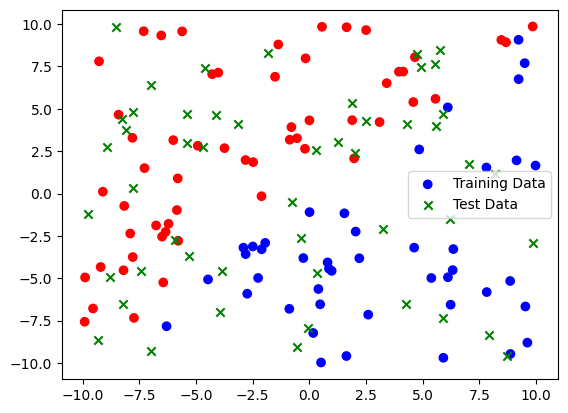

In [8]:
import matplotlib.pyplot as plt

plt.scatter(Xtr[:, 0], Xtr[:, 1], c=Ytr, cmap='bwr', label='Training Data')
plt.scatter(Xte[:, 0], Xte[:, 1], c='green', marker='x', label='Test Data')
plt.legend()
plt.show()

In [9]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte, Xtr)
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # Hint 1: take all the distances for the current test point
        # Hint 2: Sort the indices of the distances
        # Hint 3: Get the indices of the k lowest of distances
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.

        distances = dist[idx]
        sorted_indices = np.argsort(distances) # using argosrt to sort the indices
        k_nearest_indices = sorted_indices[:k] # getting the indices of the k lowest distances
        nearest_values = Ytr[k_nearest_indices] # getting the values of k indices
        mean_label = np.mean(nearest_values) # computing the mean of the output values   
        Ypred[idx] = np.sign(mean_label) # takin gthe sign of it 
        
    return Ypred

k = 3
kNNClassify(Xtr, Ytr, k, Xte)

array([ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.])

### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [10]:
def separatingFkNN(Xtr, Ytr, k, Xte, ax=None):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    if ax is None:
        # Create a new figure and axis if ax is not provided
        fig, ax = plt.subplots()

    # Plot the separating function on the provided axis
    CS = ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    
    # Plot the data points
    ax.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(x.min(), x.max())
    
    # Set the title
    msg = 'Separating function, k=' + str(k)
    ax.set_title(msg)


### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [11]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 2: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



With K=1 the error on the test set is  0.04
With K=1 the error on the training set is  0.0


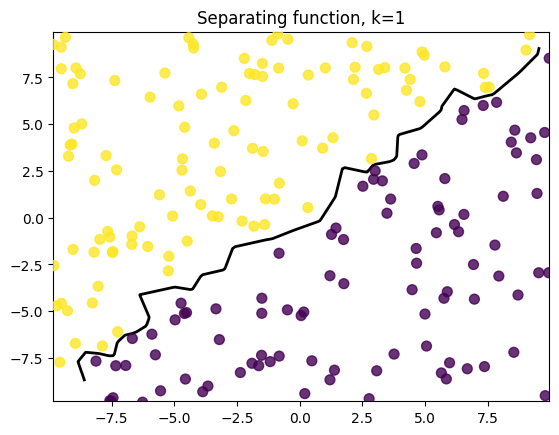

In [12]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# # How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

### Assignment 3: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

With K=1 the error on the test set is  0.16
With K=1 the error on the training set is  0.0


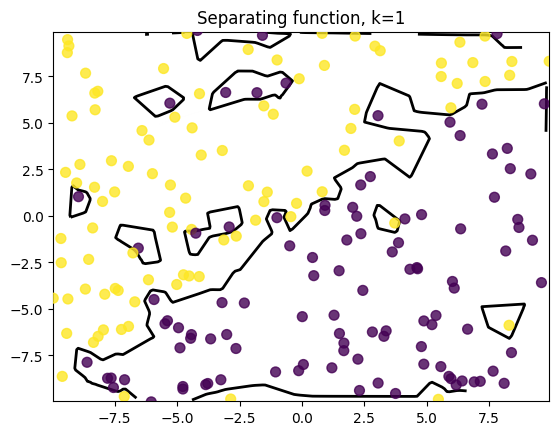

In [13]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

#TODO: Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

P = 10
Ytr = flipLabels(Ytr, P)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# # How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

With K=5 the error on the test set is  0.045
With K=5 the error on the training set is  0.1


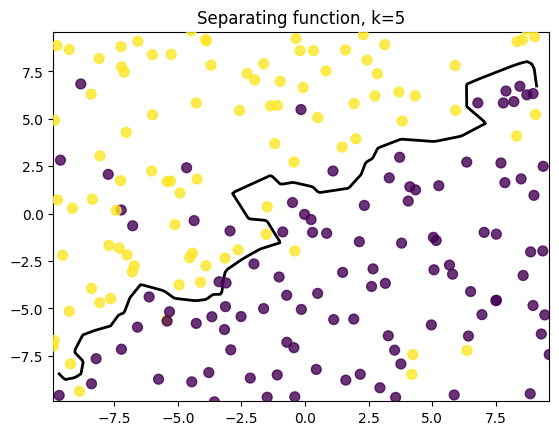

In [14]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 5

Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

P = 10
Ytr = flipLabels(Ytr, P)

separatingFkNN(Xtr, Ytr, k, Xtr)

Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

Ypred = kNNClassify(Xtr, Ytr, k, Xte)

err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# # How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

## Describe here what changes: 
-   With k = 1: the model overfits the data. As it is visible in the first plot, the decision boundary is highly irregular and tightly follows the training data, even capturing small regios of points (both yellow and purple). This is due the high variance and low bias.
-   With k = 5: The decsion boundary becomes smoother and more generalized. as seen in the second plot. The separating curve now caputes the general trends in the data but no longer follows the noise or outliers as closely. This results in an increase in bias but a reduction in variance.

### Assignment 4

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

For each scenario, describe what happen

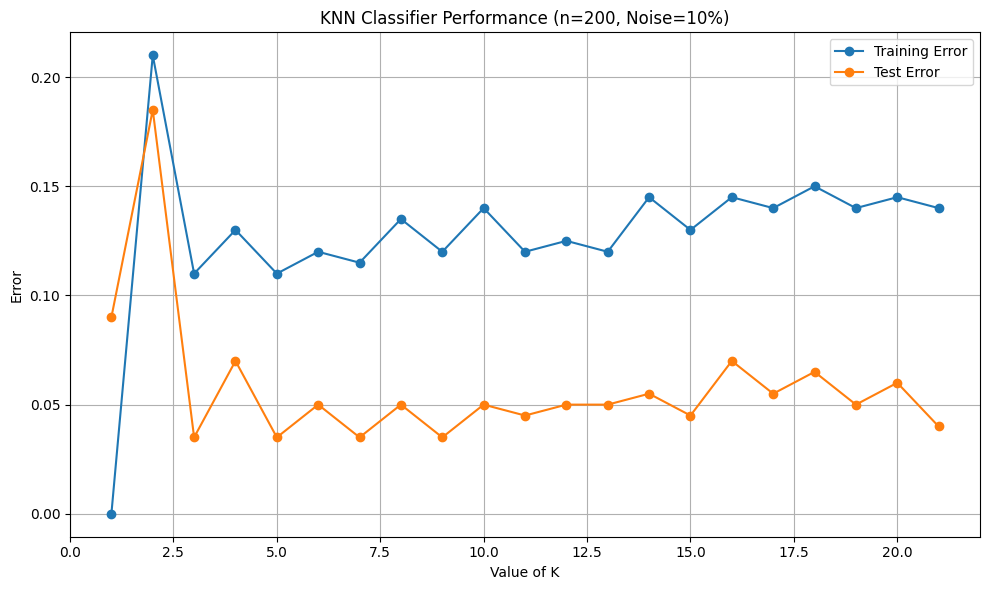

In [15]:
n = 200
D = 2
m = 0.9
q = 0.0
low_D = -10
high_D = 10
P = 10
steps = range(1, 22)

train_errors = []
test_errors = []

Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, P)

for k in steps:
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)

    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)

plt.figure(figsize=(10, 6))
plt.plot(steps, train_errors, label="Training Error", marker='o')
plt.plot(steps, test_errors, label="Test Error", marker='o')
plt.xlabel("Value of K")
plt.ylabel("Error")
plt.title(f'KNN Classifier Performance (n=200, Noise={P}%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


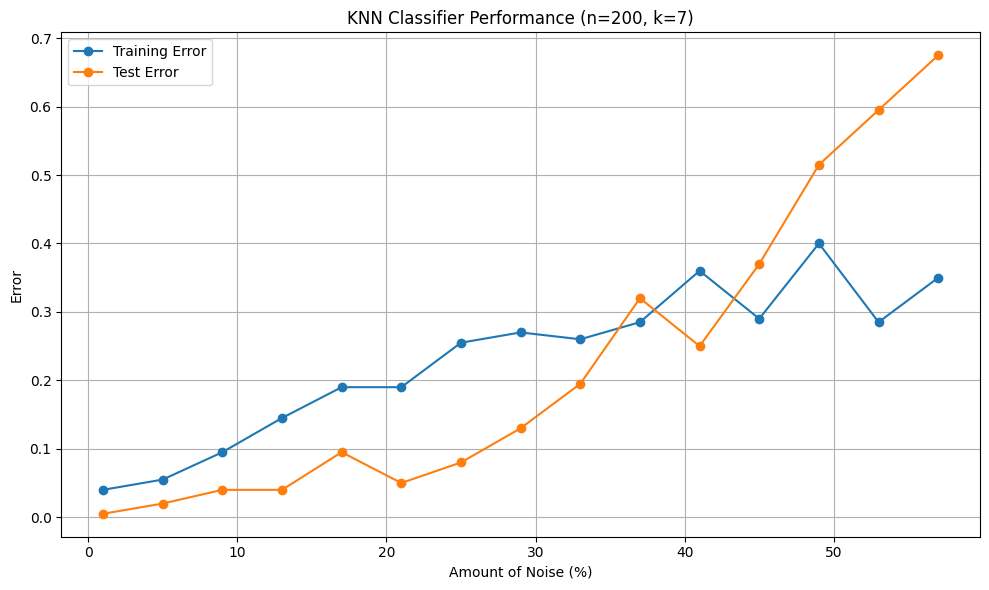

In [16]:
n = 200
D = 2
m = 0.9
q = 0.0
low_D = -10
high_D = 10
k = 7
steps = range(1, 58, 4)

train_errors = []
test_errors = []

Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

for P in steps:
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
    Ytr = flipLabels(Ytr, P)

    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)

    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)

plt.figure(figsize=(10, 6))
plt.plot(steps, train_errors, label="Training Error", marker='o')
plt.plot(steps, test_errors, label="Test Error", marker='o')
plt.xlabel("Amount of Noise (%)")
plt.ylabel("Error")
plt.title(f'KNN Classifier Performance (n=200, k={k})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training size: 30, Train error: 0.16666666666666666, Test error: 0.11
Training size: 60, Train error: 0.15, Test error: 0.07
Training size: 90, Train error: 0.12222222222222222, Test error: 0.08
Training size: 120, Train error: 0.09166666666666666, Test error: 0.05333333333333334
Training size: 150, Train error: 0.11333333333333333, Test error: 0.02666666666666667
Training size: 180, Train error: 0.12222222222222222, Test error: 0.043333333333333335
Training size: 210, Train error: 0.11428571428571428, Test error: 0.013333333333333334
Training size: 240, Train error: 0.1125, Test error: 0.03666666666666667
Training size: 270, Train error: 0.11481481481481481, Test error: 0.02666666666666667
Training size: 300, Train error: 0.10333333333333333, Test error: 0.023333333333333334


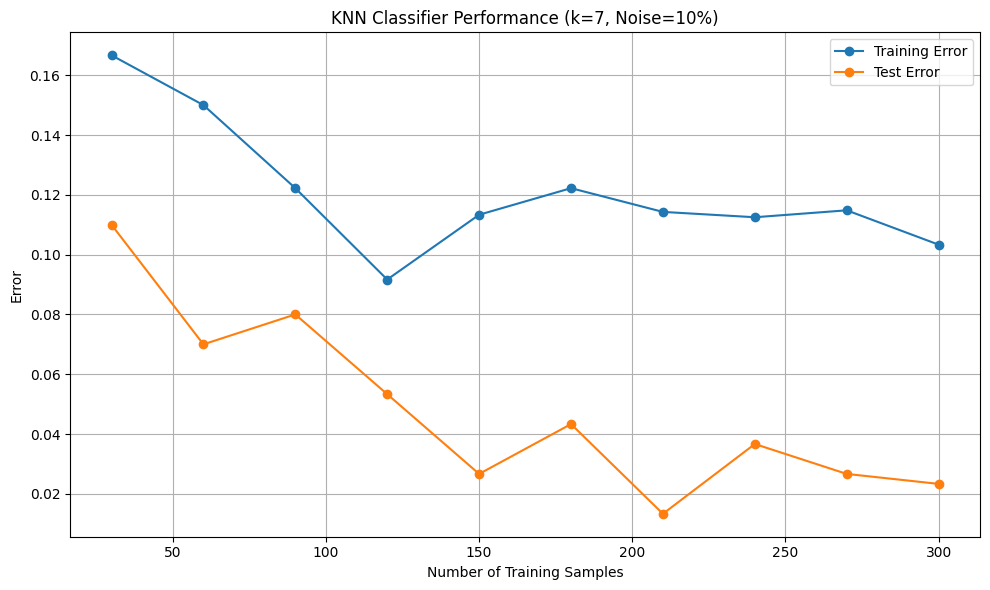

In [88]:
P = 10  
k = 7  
n_test = 300  
steps = range(30, 301, 30) 

train_errors = []
test_errors = []

low_D = -10
high_D = 10
m = 0.9
q = 0.0
Xte, Yte = linearBinaryClass(n_test, low_D, high_D, m, q)

for n_train in steps:
    Xtr, Ytr = linearBinaryClass(n_train, low_D, high_D, m, q)
    Ytr = flipLabels(Ytr, P)

    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)  


    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)  

    print(f"Training size: {n_train}, Train error: {errtr}, Test error: {err}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(steps, train_errors, label="Training Error", marker='o')
plt.plot(steps, test_errors, label="Test Error", marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("Error")
plt.title(f'KNN Classifier Performance (k={k}, Noise={P}%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Insert here your observations:
- **SCENARIO 1**:
    1. Low K:
        - The training error is very low, especially for k=1, where it is close to zero. This indicates that the model is overfitting the training data, memorizing the noise and outliers, hence leading to poor generalization.
        - The test error spikes for small k values, especially at k=2, where it reaches a high of around 0.20. This is a classic sign of overfitting, where the model is too sensitive to the specific data points and noise, failing to generalize to unseen data.
    2. Increasing K: 
        - As k increases, both training and test errors begin to stabilize. The training error increases slightly, while the test error decreases, suggesting that the model is balancing bias and variance better. The test error remains low (hovering around 0.05), indicating improved generalization at these values of k.
        - This range represents the sweet spot for k, where the model has reduced its overfitting tendencies while still maintaining flexibility to capture important patterns in the data.
    3. Higher K:
        - With further increases in k, the training error plateaus or slightly increases, but the test error remains relatively low. This indicates that the model is now somewhat underfitting—becoming too simple to capture finer details of the data, but still managing to generalize reasonably well.
        - The test error fluctuates around 0.05 to 0.08, suggesting that the model is slightly biased but still performing decently on unseen data.
The optimal range for k in this scenario seems to be around k=5 to k=10, where the test error is minimized, and the model generalizes well. For very small k, the model overfits, while for larger k, the model underfits slightly but still generalizes reasonably well.




- **SCENARIO 2**:
    1. Low Noise levels (1% - 9%):
        - At very low noise levels, both training error and test error are small. The test error remains almost zero initially, indicating that the model is able to generalize well with clean data.
        
        - As noise increases, the training error begins to rise gradually, but the test error remains relatively low, suggesting that the model is still handling the added noise effectively up to around 20%.

    2. Moderate Noise Levels (13% - 29%): 
        - Both training and test errors begin to increase more significantly in this range. As noise continues to increase, the model starts to struggle with generalization, and the test error starts rising more sharply.

        - Around 30-40% noise, the test error fluctuates, indicating that the model’s performance becomes less stable as the noise level increases. The training error also follows this trend, suggesting that the model is now overfitting some of the noise in the training set.
    3. High Noise Levels (33% - 49%):
        - As noise reaches 40% and beyond, both the training and test errors increase sharply. The test error climbs steeply, reaching around 0.65 at 57% noise. This suggests that the model is unable to generalize effectively as the training data becomes increasingly noisy.

        - The training error also increases, indicating that the model is overfitting the noisy data but still performing poorly on the test set due to the noise overwhelming the signal.

As the amount of noise increases, the performance of the kNN classifier degrades significantly. At low noise levels, the model performs well with minimal errors. However, as noise increases beyond 20-30%, the model struggles to generalize, with both training and test errors rising sharply. By the time noise reaches 57%, the model is effectively overwhelmed by the noise, leading to poor performance. This analysis highlights how sensitive kNN is to noisy data and the importance of noise management in training datasets.


- **SCENARIO 3**:
In this scenario, as the number of training samples increases, both training and test errors decrease. Initially, the model suffers from high variance due to small training data, but as more samples are added (around 120-150), test error reaches its lowest point (~0.03), indicating good generalization. After that, adding more samples does not significantly improve performance, showing the model has hit its bias limit. This highlights the need for sufficient training data to balance bias and variance, especially with noise present.